In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import sys
import os
from keras.applications.vgg16 import VGG16
import keras
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.optimizers import SGD
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import img_to_array
from keras.layers import Dropout

from tensorflow.keras.layers import BatchNormalization

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import matplotlib.pyplot as plt
import os
import PIL
import random
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
import pathlib

In [3]:
data_dir = "/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset"

In [4]:
input_dir = '/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset'
output_dir = '/kaggle/working/dataset'

os.makedirs(output_dir, exist_ok=True)
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
val_dir = os.path.join(output_dir, 'val')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [5]:
random.seed(42)

# List all the classes in the dataset
classes = os.listdir(input_dir)

# Loop through each class and divide images into train, test, and validation sets
for class_name in classes:
    class_dir = os.path.join(input_dir, class_name)
    images = os.listdir(class_dir)
    random.shuffle(images)

    # Calculate the number of images for each subset
    num_images = len(images)
    num_train = int(0.7 * num_images)
    num_test = int(0.2 * num_images)
    num_val = num_images - num_train - num_test

    # Divide images into subsets
    train_images = images[:num_train]
    test_images = images[num_train:num_train+num_test]
    val_images = images[num_train+num_test:]

    # Move images to the respective directories
    for image in train_images:
        src = os.path.join(class_dir, image)
        dst = os.path.join(train_dir, class_name, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for image in test_images:
        src = os.path.join(class_dir, image)
        dst = os.path.join(test_dir, class_name, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for image in val_images:
        src = os.path.join(class_dir, image)
        dst = os.path.join(val_dir, class_name, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

In [6]:
num_train_images = sum(len(files) for _, _, files in os.walk(train_dir))
num_test_images = sum(len(files) for _, _, files in os.walk(test_dir))
num_val_images = sum(len(files) for _, _, files in os.walk(val_dir))

# Print the counts
print("Train images:", num_train_images)
print("Test images:", num_test_images)
print("Validation images:", num_val_images)

Train images: 618
Test images: 174
Validation images: 93


In [7]:
traindir = "/kaggle/working/dataset/train"
validdir = "/kaggle/working/dataset/val"
testdir = "/kaggle/working/dataset/test"

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 50
training_set = train_datagen.flow_from_directory(traindir,
                                                 target_size=(224, 224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

valid_set = valid_datagen.flow_from_directory(validdir,
                                            target_size=(224, 224),
                                            batch_size=batch_size,
                                            class_mode='categorical')

Found 618 images belonging to 8 classes.
Found 93 images belonging to 8 classes.


In [8]:
class_dict = training_set.class_indices
print(class_dict)

{'Anthracnose': 0, 'algal leaf': 1, 'bird eye spot': 2, 'brown blight': 3, 'gray light': 4, 'healthy': 5, 'red leaf spot': 6, 'white spot': 7}


In [9]:
li = list(class_dict.keys())
print(li)

['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


In [10]:
train_num = training_set.samples
valid_num = valid_set.samples

In [11]:
base_model=VGG16(include_top=False,input_shape=(224,224,3))
base_model.trainable=False

58889256/58889256 [==============================] - 3s 0us/step


In [12]:
classifier=keras.models.Sequential()
classifier.add(base_model)
classifier.add(Flatten())
classifier.add(Dense(8,activation='softmax'))
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 8)                 200712    
                                                                 
Total params: 14,915,400
Trainable params: 200,712
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
classifier.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
history = classifier.fit(training_set,
                         steps_per_epoch=train_num//batch_size,
                         validation_data=valid_set,
                         epochs=30,
                         validation_steps=valid_num//batch_size,
                         )

Epoch 1/30
12/12 [==============================] - 40s 3s/step - loss: 2.5868 - accuracy: 0.2254 - val_loss: 1.5938 - val_accuracy: 0.5200
Epoch 2/30
12/12 [==============================] - 28s 3s/step - loss: 1.3612 - accuracy: 0.4912 - val_loss: 1.1769 - val_accuracy: 0.5600
Epoch 3/30
12/12 [==============================] - 27s 2s/step - loss: 1.0769 - accuracy: 0.6232 - val_loss: 0.8372 - val_accuracy: 0.7400
Epoch 4/30
12/12 [==============================] - 29s 2s/step - loss: 0.8497 - accuracy: 0.7130 - val_loss: 1.0005 - val_accuracy: 0.6800
Epoch 5/30
12/12 [==============================] - 27s 2s/step - loss: 0.8046 - accuracy: 0.7042 - val_loss: 0.7494 - val_accuracy: 0.7200
Epoch 6/30
12/12 [==============================] - 27s 2s/step - loss: 0.7627 - accuracy: 0.7306 - val_loss: 0.7193 - val_accuracy: 0.7200
Epoch 7/30
12/12 [==============================] - 26s 2s/step - loss: 0.7010 - accuracy: 0.7658 - val_loss: 0.6957 - val_accuracy: 0.7000
Epoch 8/30
12/12 [==

In [15]:
filepath="vgg-16-Tea-leaves-disease-model.h5"
classifier.save(filepath)

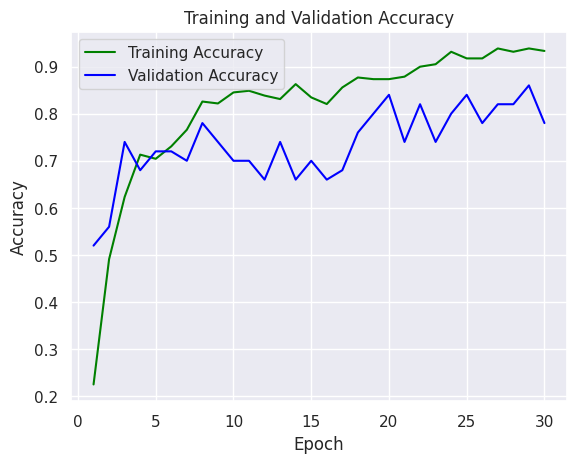

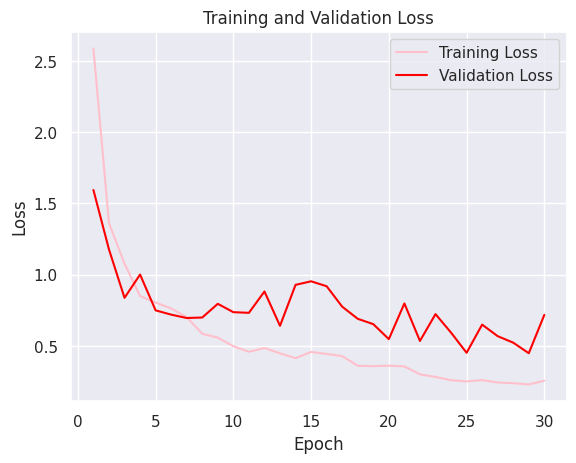

In [16]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Following is our prediction:
1/1 [==============================] - 0s 21ms/step


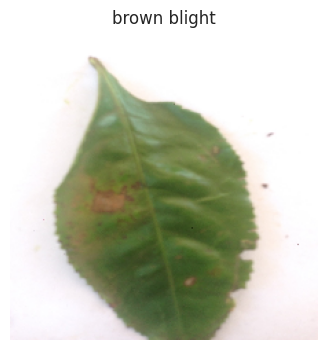

In [19]:
import keras.utils as image
import numpy as np
image_path = "/kaggle/working/dataset/test/brown blight/UNADJUSTEDNONRAW_thumb_15e.jpg"
new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = classifier.predict(img)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]

#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()